## Split into train and test set

In [1]:
import os

from datasets import load_from_disk
from transformers import Qwen2VLForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from qwen_vl_utils import process_vision_info
from PIL import Image
from datasets import load_dataset
import pandas as pd
print(os.getcwd())
os.chdir("../src")
#print(os.getcwd())
from qwen_finetune import train_and_validate


from qwen_finetune import *
from train_test import *
from tqdm import tqdm
import time
import wandb
from random import random
import time

wandb.login(key = "3708195e26856c0278c92195c8d374200262cf6f")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/alex/projects/ocr/scripts


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alex/.netrc
wandb: Currently logged in as: alex-zdz (alex-zdz-university-of-klagenfurt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [67]:
free, total = torch.cuda.mem_get_info()
print(f"Free: {free/1024**2:.2f} MB")
print(f"Total: {total/1024**2:.2f} MB")
print(f"Used: {(total-free)/1024**2:.2f} MB")
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
import gc
gc.collect()  

Free: 24663.31 MB
Total: 45466.25 MB
Used: 20802.94 MB


0

# Individual Cells for understanding:
## train_and_validate setup:

In [15]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"
#qwen_model = "Qwen/Qwen2.5-VL-72B-Instruct"

Split twice: first into train and rest and then the rest into validation and test set, or train + validation AND test set

In [25]:
# Load the combined dataset from the processed directory
path = "../data/processed_singlecol/dataset_p40"
data = load_from_disk(path)
trainval_test_split = data.train_test_split(test_size=0.2, seed=42)
test_dataset = trainval_test_split['test']
train_val_split = trainval_test_split["train"].train_test_split(test_size=0.25, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

test_dataset, train_dataset, val_dataset

(Dataset({
     features: ['id', 'transcription', 'image'],
     num_rows: 298
 }),
 Dataset({
     features: ['id', 'transcription', 'image'],
     num_rows: 893
 }),
 Dataset({
     features: ['id', 'transcription', 'image'],
     num_rows: 298
 }))

In [ ]:
#os.chdir("../src")

In [3]:
from qwen_finetune import HuggingFaceDataset, collate_fn, validate
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from functools import partial

In [ ]:
# transform dataset into nested dictionary - list - dict - list - dict form that is typical for LLMs where its fromatted like a chat 
# with the user giving the input image and request to transform it to text and the "assistant" response is the text transcription of the image, the "label" = the ground truth transcription
tst = HuggingFaceDataset(train_dataset, image_column="image",
                            text_column="transcription",
                            user_text="Convert this image to text")


In [62]:
tst[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=36x84>},
    {'type': 'text', 'text': 'Convert this image to text'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': '唐甲'}]}]}

In [75]:
min_pixel=256
max_pixel=384
image_factor=28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixel*image_factor*image_factor, max_pixels=max_pixel*image_factor*image_factor, padding_side="right")

In [73]:
train_loader = DataLoader(
        tst,
        batch_size= 4,
        collate_fn=partial(collate_fn, processor=processor, device = "cuda"),
        shuffle=True
    )

In [74]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
for batch in train_loader:
    inputs, labels = batch
    print("inputs", type(inputs) ,"input keys", inputs.keys(), "labels shape", labels.shape, "labels")
    print(batch)
   
    break

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
inputs <class 'transformers.feature_extraction_utils.BatchFeature'> input keys dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw']) labels shape torch.Size([2, 428]) labels
({'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655

✅ Summary

Each batch is:

Inputs: dictionary with text tokens, masks, image tensors, and image shape metadata.

Labels: tensor aligned with input_ids, but with -100 except where the assistant’s output should be predicted.

This is exactly what allows the model to be trained in a causal LM style with images.

In [51]:
inputs["pixel_values"][0]

tensor([1.7114, 1.6968, 1.6968,  ..., 2.0179, 2.0321, 2.0464], device='cuda:0')

Loss and Accuracy curves using weights and biases# Load and split the dataset
dataset = load_dataset(dataset_name)


https://huggingface.co/learn/llm-course/chapter3/5?fw=pt

Characteristics of healthy curves:

Smooth decline in loss: Both training and validation loss decrease steadily
Close training/validation performance: Small gap between training and validation metrics
Convergence: Curves level off, indicating the model has learned the patterns


# Computing the Loss vs Accuracy vs CER

In [6]:

    #Configuration
    learning_rate = 0.000001
    train_batch_size = 2
    #dataset = "dataset_p40"
    train_size = 200
    max_steps = 100
    eval_steps = max_steps / 10
    num_accumulation_steps = 2

    # Load the combined dataset from the processed directory
    output_dir="results/p40_test"
    path = "../data/processed_singlecol/dataset_p40"
    data = load_from_disk(path)
    # Split into train/val/test (fixed across runs!)
    trainval_test_split = data.train_test_split(test_size=0.2, seed=42)
    #test_dataset = trainval_test_split['test']
    train_val_split = trainval_test_split["train"].train_test_split(test_size=0.25, seed=42)
    val_dataset = train_val_split['test']
    train_full = train_val_split['train']

    # Subsample training set according to sweep parameter
    #train_dataset = get_train_subset(train_full, train_size)
    train_dataset = train_full

    device = "cuda"
    min_pixel=256
    max_pixel=384
    image_factor=28

    model_name = "Qwen/Qwen2-VL-2B-Instruct"
    model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_name, torch_dtype=torch.bfloat16,
            device_map = device
        )

    processor = AutoProcessor.from_pretrained(model_name, min_pixels=min_pixel*image_factor*image_factor, max_pixels=max_pixel*image_factor*image_factor, padding_side="right")

    train_dataset = HuggingFaceDataset(train_dataset, image_column="image",
                                text_column="transcription",
                                user_text="Convert this image to text")
                                
    val_dataset = HuggingFaceDataset(val_dataset, image_column="image",
                                text_column="transcription",
                                user_text="Convert this image to text")

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        collate_fn=partial(collate_fn, processor=processor, device=device),
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        collate_fn=partial(collate_fn, processor=processor, device=device)
    )


    model.train()
    optimizer = AdamW(model.parameters(), lr = learning_rate) #1e-5


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
batch = next(iter(train_loader))
#type(first_batch[0]), first_batch[0].keys()
inputs, labels = batch
#Inputs: dictionary with text tokens (tokenized numerical representations of the input text), masks (Attention masks that tell the model which tokens are meaningful and which are just padding.),
#image tensors (Shape is usually [batch_size, color channels, height, width]), and image shape metadata (nformation about the original image dimensions before resizing/cropping.).
print("inputs", type(inputs) ,"input keys", inputs.keys(), "labels shape", labels.shape, "labels")
#labels.


inputs <class 'transformers.feature_extraction_utils.BatchFeature'> input keys dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw']) labels shape torch.Size([2, 417]) labels


In [ ]:
labels.shape
# batch size, tokenized ground truth

torch.Size([2, 428])

In [58]:
print(type(model))
help(model)


<class 'transformers.models.qwen2_vl.modeling_qwen2_vl.Qwen2VLForConditionalGeneration'>
Help on Qwen2VLForConditionalGeneration in module transformers.models.qwen2_vl.modeling_qwen2_vl object:

class Qwen2VLForConditionalGeneration(Qwen2VLPreTrainedModel, transformers.generation.utils.GenerationMixin)
 |  Qwen2VLForConditionalGeneration(config)
 |  
 |  Method resolution order:
 |      Qwen2VLForConditionalGeneration
 |      Qwen2VLPreTrainedModel
 |      transformers.modeling_utils.PreTrainedModel
 |      torch.nn.modules.module.Module
 |      transformers.modeling_utils.ModuleUtilsMixin
 |      transformers.utils.hub.PushToHubMixin
 |      transformers.integrations.peft.PeftAdapterMixin
 |      transformers.generation.utils.GenerationMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, config)
 |      Initialize internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, input_ids: Optional[torch.LongTensor] = None, attent

In [60]:
outputs2 = model.forward(**inputs, labels=labels)

In [ ]:
# Check if outputs and outputs2 are equal objects
#are_equal = outputs == outputs2
#print("Are outputs and outputs2 equal objects?", are_equal)
# The error occurs because '==' between two tensors with more than one element returns a tensor of bools,
# which cannot be directly interpreted as a single boolean value.
# To check if two tensors are equal in all elements, use torch.equal().
# If outputs and outputs2 are not tensors but model output objects, compare their .loss attributes.

import torch

if hasattr(outputs, "loss") and hasattr(outputs2, "loss"):
    are_equal = torch.equal(outputs.loss, outputs2.loss)
    print("Are outputs.loss and outputs2.loss equal?", are_equal, hasattr(outputs, "loss"))
else:
    # If outputs are tensors
    are_equal = torch.equal(outputs, outputs2)
    print("Are outputs and outputs2 equal objects?", are_equal)


Are outputs.loss and outputs2.loss equal? True True


In [ ]:
outputs = model(**inputs, labels=labels) # is equal to model.forward
type(outputs.loss )
loss = outputs.loss
loss.backward()

In [ ]:
in

In [14]:
loss

tensor(1.9308, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:

    global_step = 0
    #while global_step < max_steps:
        for batch in train_loader:
            global_step += 1
            inputs, labels = batch
            outputs = model(**inputs, labels=labels)
            
            loss = outputs.loss / num_accumulation_steps
            loss.backward()
            
            if global_step % num_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix({"loss": loss.item() * num_accumulation_steps})

            # Perform evaluation and save model every EVAL_STEPS
            
            if global_step % eval_steps == 0 or global_step == max_steps:

                #avg_val_loss = validate(model, val_loader)

                model.eval()
                total_val_loss = 0
                correct = 0
                total = 0
                #total_chars = 0
                total_cer = 0   
                with torch.no_grad():
                    for batch in tqdm(val_loader, desc = "Validating"):
                        inputs, labels = batch
                        outputs = model(**inputs, labels=labels)
                        loss = outputs.loss
                        total_val_loss += loss.item()

                        # move labels to model's device
                        labels = labels.to(device)
                        # Get predicted class IDs
                        logits = outputs.logits  # [batch_size, seq_len, vocab_size]
                        preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

                        # Flatten tensors
                        preds = preds.view(-1)
                        labels = labels.view(-1)

                        # Create mask to ignore padding (-100)
                        mask = labels != -100

                        # Apply mask and update counts
                        correct += (preds[mask] == labels[mask]).sum().item()
                        total += mask.sum().item()

                            # Prepare for decoding (replace -100 with pad_token_id)
                        labels_to_decode = labels.clone()
                        labels_to_decode[~mask] = processor.tokenizer.pad_token_id

                        preds_to_decode = preds.clone()
                        preds_to_decode[~mask] = processor.tokenizer.pad_token_id

                        # Decode to text
                        gt_text = processor.batch_decode(labels_to_decode.view(1, -1).cpu().tolist(),
                                                        skip_special_tokens=True)[0]
                        pred_text = processor.batch_decode(preds_to_decode.view(1, -1).cpu().tolist(),
                                                        skip_special_tokens=True)[0]

                        # Compute CER
                        total_cer += compute_CER(gt_text, pred_text)

                avg_val_loss = total_val_loss / len(val_loader)
                val_acc = correct / total if total > 0 else 0.0
                val_cer = total_cer / len(val_loader) if len(val_loader) > 0 else 0.0
                #
                model.train() 

                # Save the model and processor
                save_dir = os.path.join(output_dir, f"model_step_{global_step}")
                os.makedirs(save_dir, exist_ok=True)
                model.save_pretrained(save_dir)
                processor.save_pretrained(save_dir)

                elapsed_time = time.time() - start_time

                # Log metrics to wandb.
                #run.log({"loss": avg_val_loss, "elapsed_time": elapsed_time})
                run.log({
                    "loss": avg_val_loss,
                    "accuracy": val_acc,
                    "CER": val_cer,
                    "step": global_step,
                    "elapsed_time": elapsed_time
                })

                # Set the model back to training mode
                model.train()  

            if global_step >= max_steps:
                save_dir = os.path.join(output_dir, f"final")
                model.save_pretrained(save_dir)
                processor.save_pretrained(save_dir)
                break

    # Finish the run and upload any remaining data.
    #run.finish()

    progress_bar.close()

# Weights and Biases Tryout

In [3]:

wandb.login(key = "3708195e26856c0278c92195c8d374200262cf6f")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alex/.netrc
wandb: Currently logged in as: alex-zdz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="alex-zdz",
    # Set the wandb project where this run will be logged.
    project="my-awesome-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


In [11]:

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

acc,▁▅▃▄█▇▇▇
loss,█▅▂▄▁▂▁▁
acc,0.71182
loss,0.23767


Capture a dictionary of hyperparameters
Save a dictionary of hyperparameters such as learning rate or model type. The model settings you capture in config are useful later to organize and query your results.

Need to make sure to align the names in the wandb configuration and our finetuning function

# wandb with our model

In [13]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="alex-zdz",
    # Set the wandb project where this run will be logged.
    project="ocr_01",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.00001,
        "val_batch_size": 1,
        "train_batch_size": 3,
        "dataset": "dataset_p40",
        "eval_steps": 2,
        "max_steps": 10,
        "num_accumulation_steps": 2,
    },
)


In [ ]:

# Configuration

learning_rate = run.config.learning_rate
val_batch_size = run.config.val_batch_size
train_batch_size = run.config.train_batch_size
dataset = run.config.dataset
eval_steps = run.config.eval_steps
max_steps = run.config.max_steps
num_accumulation_steps = run.config.num_accumulation_steps

# Load the combined dataset from the processed directory
output_dir="results/p40_test"
path = "../data/processed_singlecol/dataset_p40"
data = load_from_disk(path)
trainval_test_split = data.train_test_split(test_size=0.2)
test_dataset = trainval_test_split['test']
train_val_split = trainval_test_split["train"].train_test_split(test_size=0.25)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

device = "cuda"
min_pixel=256
max_pixel=384from qwen_finetune import train_and_validate
image_factor=28

model_name = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_name, torch_dtype=torch.bfloat16,
        device_map = device
    )

processor = AutoProcessor.from_pretrained(model_name, min_pixels=min_pixel*image_factor*image_factor, max_pixels=max_pixel*image_factor*image_factor, padding_side="right")

train_dataset = HuggingFaceDataset(train_dataset, image_column="image",
                            text_column="transcription",
                            user_text="Convert this image to text")
                            
val_dataset = HuggingFaceDataset(val_dataset, image_column="image",
                            text_column="transcription",
                            user_text="Convert this image to text")

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    collate_fn=partial(collate_fn, processor=processor, device=device),
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    collate_fn=partial(collate_fn, processor=processor, device=device)
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


In [17]:
def train():

    model.train()
    optimizer = AdamW(model.parameters(), lr = learning_rate) #1e-5

    global_step = 0
    progress_bar = tqdm(total=max_steps, desc="Training")
    start_time = time.time()
    while global_step < max_steps:
        for batch in train_loader:
            global_step += 1
            inputs, labels = batch
            outputs = model(**inputs, labels=labels)
            
            loss = outputs.loss / num_accumulation_steps
            loss.backward()
            
            if global_step % num_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix({"loss": loss.item() * num_accumulation_steps})

            # Perform evaluation and save model every EVAL_STEPS
            
            if global_step % eval_steps == 0 or global_step == max_steps:

                #avg_val_loss = validate(model, val_loader)

                model.eval()
                total_val_loss = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch in tqdm(val_loader, desc = "Validating"):
                        inputs, labels = batch
                        outputs = model(**inputs, labels=labels)
                        loss = outputs.loss
                        total_val_loss += loss.item()

                        # move labels to model's device
                        labels = labels.to(device)
                        # Get predicted class IDs
                        logits = outputs.logits  # [batch_size, seq_len, vocab_size]
                        preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

                        # Flatten tensors
                        preds = preds.view(-1)
                        labels = labels.view(-1)

                        # Create mask to ignore padding (-100)
                        mask = labels != -100

                        # Apply mask and update counts
                        correct += (preds[mask] == labels[mask]).sum().item()
                        total += mask.sum().item()


                avg_val_loss = total_val_loss / len(val_loader)
                accuracy = correct / total if total > 0 else 0.0
                #
                model.train() 

                # Save the model and processor
                save_dir = os.path.join(output_dir, f"model_step_{global_step}")
                os.makedirs(save_dir, exist_ok=True)
                model.save_pretrained(save_dir)
                processor.save_pretrained(save_dir)

                elapsed_time = time.time() - start_time

                # Log metrics to wandb.
                #run.log({"loss": avg_val_loss, "elapsed_time": elapsed_time})
                run.log({"acc": accuracy, "loss": avg_val_loss, "step": global_step,
                        "elapsed_time": elapsed_time})

                # Set the model back to training mode
                model.train()  

            if global_step >= max_steps:
                save_dir = os.path.join(output_dir, f"final")
                model.save_pretrained(save_dir)
                processor.save_pretrained(save_dir)
                break

    # Finish the run and upload any remaining data.
    run.finish()

    progress_bar.close()


## Testing it as a function

In [ ]:
train()

## Equivalent to running this cell

In [83]:

model.train()
optimizer = AdamW(model.parameters(), lr = learning_rate) #1e-5

global_step = 0
progress_bar = tqdm(total=max_steps, desc="Training")
start_time = time.time()
while global_step < max_steps:
    for batch in train_loader:
        global_step += 1
        inputs, labels = batch
        outputs = model(**inputs, labels=labels)
        
        loss = outputs.loss / num_accumulation_steps
        loss.backward()
        
        if global_step % num_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        progress_bar.set_postfix({"loss": loss.item() * num_accumulation_steps})

        # Perform evaluation and save model every EVAL_STEPS
        
        if global_step % eval_steps == 0 or global_step == max_steps:

            #avg_val_loss = validate(model, val_loader)

            model.eval()
            total_val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in tqdm(val_loader, desc = "Validating"):
                    inputs, labels = batch
                    outputs = model(**inputs, labels=labels)
                    loss = outputs.loss
                    total_val_loss += loss.item()

                    # move labels to model's device
                    labels = labels.to(device)
                     # Get predicted class IDs
                    logits = outputs.logits  # [batch_size, seq_len, vocab_size]
                    preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

                    # Flatten tensors
                    preds = preds.view(-1)
                    labels = labels.view(-1)

                    # Create mask to ignore padding (-100)
                    mask = labels != -100

                    # Apply mask and update counts
                    correct += (preds[mask] == labels[mask]).sum().item()
                    total += mask.sum().item()


            avg_val_loss = total_val_loss / len(val_loader)
            accuracy = correct / total if total > 0 else 0.0
            #
            model.train() 

            # Save the model and processor
            save_dir = os.path.join(output_dir, f"model_step_{global_step}")
            os.makedirs(save_dir, exist_ok=True)
            model.save_pretrained(save_dir)
            processor.save_pretrained(save_dir)

            elapsed_time = time.time() - start_time

            # Log metrics to wandb.
            #run.log({"loss": avg_val_loss, "elapsed_time": elapsed_time})
            run.log({"acc": accuracy, "loss": avg_val_loss, "step": global_step,
                     "elapsed_time": elapsed_time})

            # Set the model back to training mode
            model.train()  

        if global_step >= max_steps:
            save_dir = os.path.join(output_dir, f"final")
            model.save_pretrained(save_dir)
            processor.save_pretrained(save_dir)
            break

# Finish the run and upload any remaining data.
run.finish()

progress_bar.close()


Validating: 100%|██████████| 298/298 [00:18<00:00, 15.85it/s]s=1.75]


acc,▄▁█▁▄
elapsed_time,▁▃▅▆█
loss,█▆▄▂▁
step,▁▃▅▆█
acc,0.00107
elapsed_time,132.26099
loss,1.53531
step,10


Training: 100%|██████████| 10/10 [02:20<00:00, 14.03s/it, loss=1.75]


In [132]:
run.finish()

In [81]:
correct, total, accuracy
labels.shape,
inputs
logits.shape

torch.Size([1, 393, 151936])

In [ ]:
#run.finish()

# Try out Sweeping in wandb

In [7]:
path = "../data/processed_singlecol/dataset_p40"
data = load_from_disk(path)
total_data_length = len(data)
total_data_length


1489

### Start with sweeping previous code

In [57]:
sweep_configuration = {
    "method": "grid",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "learning_rate":  {"values": [0.000001, 0.00001, 0.0001]},
        "train_batch_size": {"values": [2]},
        "train_size": {"values": [200, 400, 800, 1200, "full"]},  
        "max_steps":  {"values": [10000]},
    },
}

In [58]:
def get_train_subset(train_full, size):
    """Return a training subset of the desired size. 'full' returns the entire training set."""
    if size == "full":
        return train_full
    else:
        size = min(int(size), len(train_full))
        return train_full.shuffle(seed=42).select(range(size))

In [29]:
def train(): #config=None
    with wandb.init(project="ocr_sweep_test_01") as run:
        config = run.config
        #Configuration
        learning_rate = config.learning_rate
        val_batch_size = 1
        train_batch_size = config.train_batch_size
        #dataset = "dataset_p40"
        train_size = config.train_size
        max_steps = config.max_steps
        eval_steps = max_steps / 10
        num_accumulation_steps = 2

        # Load the combined dataset from the processed directory
        output_dir="results/p40_test"
        path = "../data/processed_singlecol/dataset_p40"
        data = load_from_disk(path)
        # Split into train/val/test (fixed across runs!)
        trainval_test_split = data.train_test_split(test_size=0.2, seed=42)
        #test_dataset = trainval_test_split['test']
        train_val_split = trainval_test_split["train"].train_test_split(test_size=0.25, seed=42)
        val_dataset = train_val_split['test']
        train_full = train_val_split['train']

        # Subsample training set according to sweep parameter
        train_dataset = get_train_subset(train_full, train_size)

        device = "cuda"
        min_pixel=256
        max_pixel=384
        image_factor=28

        model_name = "Qwen/Qwen2-VL-2B-Instruct"
        model = Qwen2VLForConditionalGeneration.from_pretrained(
                model_name, torch_dtype=torch.bfloat16,
                device_map = device
            )

        processor = AutoProcessor.from_pretrained(model_name, min_pixels=min_pixel*image_factor*image_factor, max_pixels=max_pixel*image_factor*image_factor, padding_side="right")

        train_dataset = HuggingFaceDataset(train_dataset, image_column="image",
                                    text_column="transcription",
                                    user_text="Convert this image to text")
                                    
        val_dataset = HuggingFaceDataset(val_dataset, image_column="image",
                                    text_column="transcription",
                                    user_text="Convert this image to text")

        train_loader = DataLoader(
            train_dataset,
            batch_size=train_batch_size,
            collate_fn=partial(collate_fn, processor=processor, device=device),
            shuffle=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            collate_fn=partial(collate_fn, processor=processor, device=device)
        )


        model.train()
        optimizer = AdamW(model.parameters(), lr = learning_rate) #1e-5

        global_step = 0
        progress_bar = tqdm(total=max_steps, desc="Training")
        start_time = time.time()
        while global_step < max_steps:
            for batch in train_loader:
                global_step += 1
                inputs, labels = batch
                outputs = model(**inputs, labels=labels)
                
                loss = outputs.loss / num_accumulation_steps
                loss.backward()
                
                if global_step % num_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update(1)
                progress_bar.set_postfix({"loss": loss.item() * num_accumulation_steps})

                # Perform evaluation and save model every EVAL_STEPS
                
                if global_step % eval_steps == 0 or global_step == max_steps:

                    #avg_val_loss = validate(model, val_loader)

                    model.eval()
                    total_val_loss = 0
                    correct = 0
                    total = 0
                    #total_chars = 0
                    total_cer = 0   
                    with torch.no_grad():
                        for batch in tqdm(val_loader, desc = "Validating"):
                            inputs, labels = batch
                            outputs = model(**inputs, labels=labels)
                            loss = outputs.loss
                            total_val_loss += loss.item()

                            # move labels to model's device
                            labels = labels.to(device)
                            # Get predicted class IDs
                            logits = outputs.logits  # [batch_size, seq_len, vocab_size]
                            preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

                            # Flatten tensors
                            preds = preds.view(-1)
                            labels = labels.view(-1)

                            # Create mask to ignore padding (-100)
                            mask = labels != -100

                            # Apply mask and update counts
                            correct += (preds[mask] == labels[mask]).sum().item()
                            total += mask.sum().item()

                             # Prepare for decoding (replace -100 with pad_token_id)
                            labels_to_decode = labels.clone()
                            labels_to_decode[~mask] = processor.tokenizer.pad_token_id

                            preds_to_decode = preds.clone()
                            preds_to_decode[~mask] = processor.tokenizer.pad_token_id

                            # Decode to text
                            gt_text = processor.batch_decode(labels_to_decode.view(1, -1).cpu().tolist(),
                                                            skip_special_tokens=True)[0]
                            pred_text = processor.batch_decode(preds_to_decode.view(1, -1).cpu().tolist(),
                                                            skip_special_tokens=True)[0]

                            # Compute CER
                            total_cer += compute_CER(gt_text, pred_text)
    
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_acc = correct / total if total > 0 else 0.0
                    val_cer = total_cer / len(val_loader) if len(val_loader) > 0 else 0.0
                    #
                    model.train() 

                    # Save the model and processor
                    save_dir = os.path.join(output_dir, f"model_step_{global_step}")
                    os.makedirs(save_dir, exist_ok=True)
                    model.save_pretrained(save_dir)
                    processor.save_pretrained(save_dir)

                    elapsed_time = time.time() - start_time

                    # Log metrics to wandb.
                    #run.log({"loss": avg_val_loss, "elapsed_time": elapsed_time})
                    run.log({
                        "loss": avg_val_loss,
                        "accuracy": val_acc,
                        "CER": val_cer,
                        "step": global_step,
                        "elapsed_time": elapsed_time
                    })

                    # Set the model back to training mode
                    model.train()  

                if global_step >= max_steps:
                    save_dir = os.path.join(output_dir, f"final")
                    model.save_pretrained(save_dir)
                    processor.save_pretrained(save_dir)
                    break

        # Finish the run and upload any remaining data.
        #run.finish()

        progress_bar.close()

In [59]:
sweep_id = wandb.sweep(sweep_configuration, project="ocr_sweep_test_01")

Create sweep with ID: wgmverv6
Sweep URL: https://wandb.ai/alex-zdz/ocr_sweep_test_01/sweeps/wgmverv6


In [60]:
wandb.agent(sweep_id, train, count=15)

wandb: Agent Starting Run: u1pujah8 with config:
wandb: 	learning_rate: 1e-06
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 200


Training: 100%|██████████| 10000/10000 [1:15:41<00:00,  2.20it/s, loss=0.243]


CER,█▃▂▂▁▁▁▁▁▁
accuracy,█▃▁▁▁▃▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
step,▁▂▃▃▄▅▆▆▇█
CER,0.42427
accuracy,0.0004
elapsed_time,4532.74506
loss,1.4845
step,10000


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3k2ojce0 with config:
wandb: 	learning_rate: 1e-06
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 400


Training: 100%|██████████| 10000/10000 [1:15:52<00:00,  2.20it/s, loss=0.901]


CER,█▄▃▂▂▂▁▁▁▁
accuracy,█▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
step,▁▂▃▃▄▅▆▆▇█
CER,0.41143
accuracy,0.0006
elapsed_time,4544.8835
loss,1.45908
step,10000


wandb: Agent Starting Run: azbb4kep with config:
wandb: 	learning_rate: 1e-06
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 800


Training: 100%|██████████| 10000/10000 [1:15:45<00:00,  2.20it/s, loss=2.13]


CER,█▄▃▂▂▂▁▁▁▁
accuracy,▁▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
step,▁▂▃▃▄▅▆▆▇█
CER,0.41305
accuracy,0.0006
elapsed_time,4538.73916
loss,1.45763
step,10000


wandb: Agent Starting Run: h8db71xo with config:
wandb: 	learning_rate: 1e-06
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 1200


Training: 100%|██████████| 10000/10000 [1:15:52<00:00,  2.20it/s, loss=1.11]


CER,█▄▃▂▂▂▁▁▁▁
accuracy,█▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
step,▁▂▃▃▄▅▆▆▇█
CER,0.40878
accuracy,0.0006
elapsed_time,4545.03581
loss,1.44662
step,10000


wandb: Agent Starting Run: vcvrus6a with config:
wandb: 	learning_rate: 1e-06
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: full


Training: 100%|██████████| 10000/10000 [1:16:08<00:00,  2.19it/s, loss=0.424]


CER,█▄▃▂▂▂▁▁▁▁
accuracy,▁▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
step,▁▂▃▃▄▅▆▆▇█
CER,0.40991
accuracy,0.0006
elapsed_time,4560.50008
loss,1.45004
step,10000


wandb: Agent Starting Run: xj7qvwmc with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 200


Training: 100%|██████████| 10000/10000 [1:17:09<00:00,  2.16it/s, loss=0.00587]


CER,▂▁▃▄▃█▅▇▄█
accuracy,▄▁█████▄██
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▄▆▆▇▇▇███
step,▁▂▃▃▄▅▆▆▇█
CER,0.28034
accuracy,0.00081
elapsed_time,4621.29136
loss,1.14818
step,10000


wandb: Agent Starting Run: 3ep5lth7 with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 400


Training: 100%|██████████| 10000/10000 [1:16:55<00:00,  2.17it/s, loss=0.00307]


CER,▆▇█▁▄▇▆▅▅▇
accuracy,▁▁██▁▁▁▁▁█
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▄▆▇▇▇████
step,▁▂▃▃▄▅▆▆▇█
CER,0.26705
accuracy,0.0004
elapsed_time,4608.14042
loss,0.93987
step,10000


wandb: Agent Starting Run: rtpmrsyt with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 800


Training: 100%|██████████| 10000/10000 [1:16:54<00:00,  2.17it/s, loss=0.00865]


CER,█▄▁▁▄▅▃▅▄▅
accuracy,▁▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▃▁▄▅▆▇▇███
step,▁▂▃▃▄▅▆▆▇█
CER,0.2193
accuracy,0.0002
elapsed_time,4606.33412
loss,0.75862
step,10000


wandb: Agent Starting Run: 39l5s748 with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 1200


Training: 100%|██████████| 10000/10000 [1:17:10<00:00,  2.16it/s, loss=0.0015]


CER,█▆▁▅▇▇▇▇▇▇
accuracy,▁▁▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▂▁▂▅▆▇▇███
step,▁▂▃▃▄▅▆▆▇█
CER,0.21176
accuracy,0.0002
elapsed_time,4623.03838
loss,0.74985
step,10000


wandb: Agent Starting Run: zaqtkl6r with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: full


Training: 100%|██████████| 10000/10000 [1:16:49<00:00,  2.17it/s, loss=0.0138]


CER,█▄▅▂▄▁▃▂▃▇
accuracy,▁▁▁▁█▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▂▁▃▄▆▇▇▇██
step,▁▂▃▃▄▅▆▆▇█
CER,0.21772
accuracy,0.0002
elapsed_time,4601.92787
loss,0.74433
step,10000


wandb: Agent Starting Run: b9atlfmb with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 200


Training: 100%|██████████| 10000/10000 [1:17:25<00:00,  2.15it/s, loss=0.0582]


CER,▅▁█▅▅▅▅█▆▆
accuracy,▅█▁▁▁▁▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▃▃▃▆▆▇▇██
step,▁▂▃▃▄▅▆▆▇█
CER,1.03817
accuracy,0.00081
elapsed_time,4637.85184
loss,7.2335
step,10000


wandb: Agent Starting Run: 765c5hbg with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 400


Training: 100%|██████████| 10000/10000 [1:16:12<00:00,  2.19it/s, loss=0.181]


CER,▂▄▁▅▃▇▃▆▆█
accuracy,██▆▃▄▄▄▄▁▂
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▃▅▆▇▇▇▇██
step,▁▂▃▃▄▅▆▆▇█
CER,0.98454
accuracy,0.01671
elapsed_time,4564.94169
loss,6.69883
step,10000


wandb: Agent Starting Run: r2zj7kr8 with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 800


Training: 100%|██████████| 10000/10000 [1:17:55<00:00,  2.14it/s, loss=0.172]


CER,█▁▃▁▃▂▂▁▁▂
accuracy,▁▆▂█▄▄▁▇▄▂
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▂▄▄▅▆▇▇██
step,▁▂▃▃▄▅▆▆▇█
CER,0.93781
accuracy,0.0314
elapsed_time,4667.13183
loss,6.06618
step,10000


wandb: Agent Starting Run: kn3c7e9s with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: 1200


Training: 100%|██████████| 10000/10000 [1:18:21<00:00,  2.13it/s, loss=0.144]


CER,█▃▂▃▅▄█▃▂▁
accuracy,██▇▆▃▄▁▄▄▄
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▂▃▄▅▆▆▆▇█
step,▁▂▃▃▄▅▆▆▇█
CER,0.82618
accuracy,0.0475
elapsed_time,4694.12197
loss,5.79826
step,10000


wandb: Agent Starting Run: 048r484w with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_steps: 10000
wandb: 	train_batch_size: 2
wandb: 	train_size: full


Training: 100%|██████████| 10000/10000 [1:17:51<00:00,  2.14it/s, loss=0.234]


CER,▅▂▁▂▅▆▅▇██
accuracy,█▅▅▅▂▃▁▁▁▁
elapsed_time,▁▂▃▃▄▅▆▆▇█
loss,▁▂▃▄▅▆▆▇██
step,▁▂▃▃▄▅▆▆▇█
CER,0.89055
accuracy,0.04046
elapsed_time,4664.46485
loss,6.07245
step,10000


In [126]:
sweep_configuration = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "learning_rate":  {"values": [0.00001]},
        "train_batch_size": {"values": [3]},
        "train_size": {"values": [400, 800]},  #, 1200, "full"
        "max_steps":  {"values": [8]},
    },
}

In [138]:
sweep_id = wandb.sweep(sweep_configuration, project="ocr_sweeps_02")

Create sweep with ID: lr2x7mfa
Sweep URL: https://wandb.ai/alex-zdz/ocr_sweeps_02/sweeps/lr2x7mfa


In [128]:
def train(config=None):
    with wandb.init(config=config):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
        config = wandb.config

        # Configuration
        learning_rate = config.learning_rate
        val_batch_size = 1
        train_batch_size = config.train_batch_size
        dataset = "dataset_p40"
        train_size = config.train_size
        max_steps = config.max_steps
        eval_steps = max_steps / 10
        num_accumulation_steps = 2

        # Load the combined dataset from the processed directory
        output_dir="results/p40_test"
        path = "../data/processed_singlecol/dataset_p40"
        data = load_from_disk(path)

        # Split into train/val/test (fixed across runs!)
        trainval_test_split = data.train_test_split(test_size=0.2, seed=42)
        test_dataset = trainval_test_split['test']
        train_val_split = trainval_test_split["train"].train_test_split(test_size=0.25, seed=42)
        val_dataset = train_val_split['test']
        train_full = train_val_split['train']

        # Subsample training set according to sweep parameter
        train_dataset = get_train_subset(train_full, train_size)

        device = "cuda"
        min_pixel=256
        max_pixel=384
        image_factor=28

        model_name = "Qwen/Qwen2-VL-2B-Instruct"
        model = Qwen2VLForConditionalGeneration.from_pretrained(
                model_name, torch_dtype=torch.bfloat16,
                device_map = device
            )

        processor = AutoProcessor.from_pretrained(model_name, min_pixels=min_pixel*image_factor*image_factor, max_pixels=max_pixel*image_factor*image_factor, padding_side="right")

        train_dataset = HuggingFaceDataset(train_dataset, image_column="image",
                                    text_column="transcription",
                                    user_text="Convert this image to text")
                                    
        val_dataset = HuggingFaceDataset(val_dataset, image_column="image",
                                    text_column="transcription",
                                    user_text="Convert this image to text")

        train_loader = DataLoader(
            train_dataset,
            batch_size=train_batch_size,
            collate_fn=partial(collate_fn, processor=processor, device=device),
            shuffle=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            collate_fn=partial(collate_fn, processor=processor, device=device)
        )
        
        model.train()
        optimizer = AdamW(model.parameters(), lr = learning_rate) #1e-5

        global_step = 0
        progress_bar = tqdm(total=max_steps, desc="Training")
        start_time = time.time()
        while global_step < max_steps:
            for batch in train_loader:
                global_step += 1
                inputs, labels = batch
                outputs = model(**inputs, labels=labels)
                
                loss = outputs.loss / num_accumulation_steps
                loss.backward()
                
                if global_step % num_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update(1)
                progress_bar.set_postfix({"loss": loss.item() * num_accumulation_steps})

                # Perform evaluation and save model every EVAL_STEPS
                
                if global_step % eval_steps == 0 or global_step == max_steps:

                    #avg_val_loss = validate(model, val_loader)

                    model.eval()
                    total_val_loss = 0
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for batch in tqdm(val_loader, desc = "Validating"):
                            inputs, labels = batch
                            outputs = model(**inputs, labels=labels)
                            loss = outputs.loss
                            total_val_loss += loss.item()

                            # move labels to model's device
                            labels = labels.to(device)
                            # Get predicted class IDs
                            logits = outputs.logits  # [batch_size, seq_len, vocab_size]
                            preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

                            # Flatten tensors
                            preds = preds.view(-1)
                            labels = labels.view(-1)

                            # Create mask to ignore padding (-100)
                            mask = labels != -100

                            # Apply mask and update counts
                            correct += (preds[mask] == labels[mask]).sum().item()
                            total += mask.sum().item()


                    avg_val_loss = total_val_loss / len(val_loader)
                    accuracy = correct / total if total > 0 else 0.0
                    #
                    model.train() 

                    # Save the model and processor
                    save_dir = os.path.join(output_dir, f"model_step_{global_step}")
                    os.makedirs(save_dir, exist_ok=True)
                    model.save_pretrained(save_dir)
                    processor.save_pretrained(save_dir)

                    elapsed_time = time.time() - start_time

                    # Log metrics to wandb.
                    #run.log({"loss": avg_val_loss, "elapsed_time": elapsed_time})
                    run.log({"acc": accuracy, "loss": avg_val_loss, "step": global_step,
                            "elapsed_time": elapsed_time, "train_size": len(train_dataset)})

                    # Set the model back to training mode
                    model.train()  

                if global_step >= max_steps:
                    save_dir = os.path.join(output_dir, f"final")
                    model.save_pretrained(save_dir)
                    processor.save_pretrained(save_dir)
                    break

        # Finish the run and upload any remaining data.
        run.finish()

        progress_bar.close()


In [129]:
wandb.agent(sweep_id, train, count=3)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
socket.send() raised exception.
socket.send() raised exception.
wandb: Agent Starting Run: xthvmy1p with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_steps: 8
wandb: 	train_batch_size: 3
wandb: 	train_size: 400


wandb: Ctrl + C detected. Stopping sweep.


# Testing the model

In [1]:
import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from transformers import Qwen2VLForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from qwen_vl_utils import process_vision_info
from PIL import Image
from datasets import load_dataset, load_from_disk
import pandas as pd
print(os.getcwd())
os.chdir("..") # change in the future
print(os.getcwd())

importlib.reload(src)

from src.train_test import *
from src.train_test import run_inference_and_calculate_cer
from copy import deepcopy

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/alex/projects/ocr/scripts
/home/alex/projects/ocr


# Load the fine-tuned model from Hugging Face Hub or from a local path

In [2]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
# From HugggingFace
#with open("data/tokens/token.txt") as f:
#    write_token = f.read()
#read_token = write_token
#model_name_p40 = 'culturalheritagenus/Gongguan-OCR-p40'
# Load the model and processor
#model_01_11 = Qwen2VLForConditionalGeneration.from_pretrained(
#    model_name_01_11,
#    token=read_token,
#    torch_dtype=torch.bfloat16,  # Use the appropriate torch dtype if needed
#    device_map='auto'            # Optional: automatically allocate model layers across devices
#)

In [7]:
os.getcwd()

'/home/alex/projects/ocr'

In [4]:

# # Locally
# model_p40 = Qwen2VLForConditionalGeneration.from_pretrained(
#     "results/p40_newindex/final",
#     device_map='auto'
# )
# # convert the model to half-precision floating point (FP16)
# model_p40.half()
# # Load the processor
# processor = AutoProcessor.from_pretrained("results/p40_newindex/final")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Load the validation dataset (load_dataset is a huggingface function) and predict using the process image function

In [6]:
# from HF
#model_name_p40 = 'culturalheritagenus/Gongguan-OCR-p40'
#dataset_p40 = load_dataset(f"{model_name_p40}", split='validation')
# Locally
# Save the dataset from HF to disk
#dataset_p40.save_to_disk("../data/processed/dataset_p40")
dataset_p40 = load_from_disk("data/processed/dataset_p40")

In [6]:
dataset_p40[0]

{'text': '美色甘 呌',
 'identifier': '12_21_p001_r_31',
 'num_lines': 2,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=122x448>}

WER not appropriate in our case, since it considers words to be separated by whitespace, which is not true for Chinese text. For now continue with CER.

# Compute predictions and CER

Define message template with instructions by the user for the LLM
This is now an input in the new "run_inference_and_calculate_cer" function

In [4]:
messages_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": None,  # Placeholder for image, to be updated
            },
            {"type": "text", "text": "Convert this image to text"},
            #{"type": "text", "text": "Convert this image to Chinese text and carefully consider when the image has multiple columns of text"},
        ],
    }
]

the following functions are part of "run_inference_and_calculate_cer" and are loaded through the src file "train_test.py"

In [27]:
# def process_image(image, model, messages_template):
#     messages = deepcopy(messages_template)
#     messages[0]["content"][0]["image"] = image
#     text = processor.apply_chat_template(
#         messages, tokenize=False, add_generation_prompt=True
#     )
#     image_inputs, video_inputs = process_vision_info(messages)
#     inputs = processor(
#         text=[text],
#         images=image_inputs,
#         videos=video_inputs,
#         padding=True,
#         return_tensors="pt",
#     )
#     inputs = inputs.to("cuda")
#     generated_ids = model.generate(**inputs, max_new_tokens=128)
#     generated_ids_trimmed = [
#         out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
#     ]
#     output_text = processor.batch_decode(
#         generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
#     )
#     return output_text[0]

In [28]:
# def compute_CER(gt_text, pred_text, normalize=True):
#         if normalize:
#             gt_text = str(gt_text)
#             gt_text = unicodedata.normalize('NFKC', gt_text)
#             gt_text = re.sub(r'\s+', ' ', gt_text).strip()
#             pred_text = str(pred_text)
#             pred_text = unicodedata.normalize('NFKC', pred_text)
#             pred_text = re.sub(r'\s+', ' ', pred_text).strip()
#         gt_chars = list(gt_text)
#         pred_chars = list(pred_text)
#         distance = levenshtein_distance(gt_chars, pred_chars)
#         cer = distance / len(gt_chars) if len(gt_chars) > 0 else 0
#         return cer

In [29]:
# def run_inference_and_calculate_cer(model_path, message_template, dataset):
#     # Load the model and processor
#     model = Qwen2VLForConditionalGeneration.from_pretrained(model_path, device_map="auto").half()
#     processor = AutoProcessor.from_pretrained(model_path)

#     results = []
#     # Run inference on the dataset
#     for item in dataset:
#         prediction = process_image(item["image"], model, message_template)
#         cer = compute_CER(item["text"], prediction, normalize=True)
#         results.append({
#             "ground_truth": item["text"],
#             "num_lines": item["num_lines"],
#             "prediction": prediction,
#             "identifier": item["identifier"],
#             "CER": cer
#         })

#     # Create DataFrame from results
#     df = pd.DataFrame(results)

#     return df


In [13]:
dataset_p40.shape

(661, 4)

In [42]:
#res = run_inference_and_calculate_cer("results/p40_newindex/final", messages_template, dataset_p40.select(range(300)))

In [7]:
res = run_inference_and_calculate_cer("results/p40_newindex/final", messages_template, dataset_p40)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
res.shape

(661, 5)

In [10]:
# Save predictions to CSV
res.to_csv('results/predictions/p40.csv', index=False)

In [13]:

#res = pd.read_csv('results/predictions/p40.csv')
res.iloc[10], dataset_p40[10]


(ground_truth              22
 num_lines                  1
 prediction                22
 identifier      12_21_p001_r
 CER                      0.0
 Name: 10, dtype: object,
 {'text': '22',
  'identifier': '12_21_p001_r',
  'num_lines': 1,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=106x89>})

Check whether order matters in multicolumn text regions

In [14]:
print(res["CER"].mean())
print(res["CER"].median())

0.41532918507545585
0.3333333333333333


# Show the CER as histogram

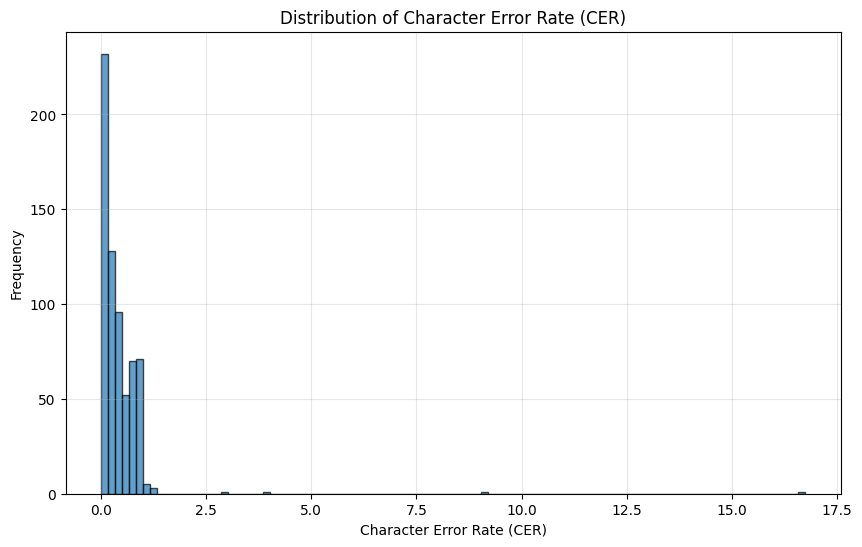

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

# Extract CER values from the results
cer_values = res['CER'].values

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(cer_values, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Character Error Rate (CER)')
plt.ylabel('Frequency')
plt.title('Distribution of Character Error Rate (CER)')
plt.grid(True, alpha=0.3)


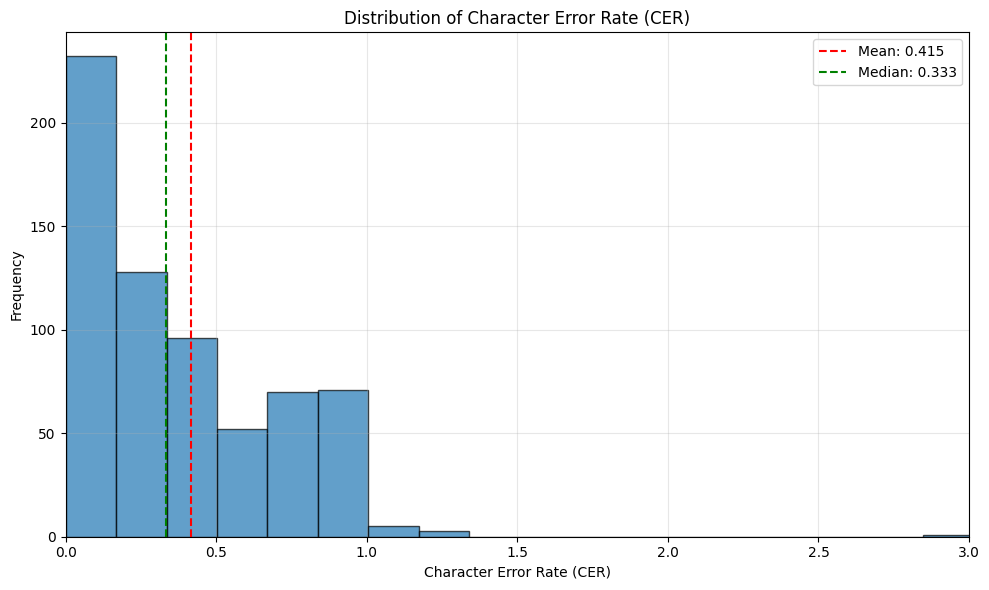

Total samples: 661
Mean CER: 0.4153
Median CER: 0.3333
Std CER: 0.8107
Min CER: 0.0000
Max CER: 16.7500


In [25]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(cer_values, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Character Error Rate (CER)')
plt.ylabel('Frequency')
plt.xlim(0, 3)
plt.title('Distribution of Character Error Rate (CER)')
plt.grid(True, alpha=0.3)
# Add some statistics
mean_cer = np.mean(cer_values)
median_cer = np.median(cer_values)
plt.axvline(mean_cer, color='red', linestyle='--', label=f'Mean: {mean_cer:.3f}')
plt.axvline(median_cer, color='green', linestyle='--', label=f'Median: {median_cer:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total samples: {len(cer_values)}")
print(f"Mean CER: {mean_cer:.4f}")
print(f"Median CER: {median_cer:.4f}")
print(f"Std CER: {np.std(cer_values):.4f}")
print(f"Min CER: {np.min(cer_values):.4f}")
print(f"Max CER: {np.max(cer_values):.4f}")

Count how many rows have a CER above 1

In [26]:
res[res['CER']>1].shape

(12, 5)

Only 12! If we exclude those, what is our new mean CER?

In [36]:
res_small = res[res['CER']<1]
round(res_small['CER'].mean(), 3), round(res["CER"].mean(), 3)
print(f"Mean CER : {round(res['CER'].mean(), 3)}")
print(f"Mean CER if excluding values above 1: {round(res_small['CER'].mean(), 3)}")


Mean CER : 0.415
Mean CER if excluding values above 1: 0.346


Let's summarize the number of columns for these results

In [49]:
res[res["CER"] > 1]["num_lines"].value_counts()

num_lines
1    3
0    3
2    3
7    1
3    1
4    1
Name: count, dtype: int64

Actually the number of columns is not particularly high for these!

What about the ones that have a higher CER among the ones below 1, maybe above 50%?

In [56]:
# Sort the DataFrame by CER
res_sorted = res.sort_values(by='CER')
res_sorted


,ground_truth,num_lines,prediction,identifier,CER
24,謝寶覌 呌,2,謝寶覌 呌,32_41_p008_r_20,0.000000
25,張賞覌,1,張賞覌,32_41_p008_r_13,0.000000
0,美色甘 呌,2,美色甘 呌,12_21_p001_r_31,0.000000
650,蔡玉振,1,蔡玉振,22_31_p003_r_33,0.000000
32,29,1,29,12_21_p004_r_21,0.000000
...,...,...,...,...,...
458,None,0,李寧義不到,12_21_p010_r_8,1.250000
388,64,1,Eugène,32_41_p002_r,3.000000
534,戊二月十九日和 年三月廿六日拜三,1,戊三月十九日和〡〧〨〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧〧...,22_31_p002_r_110,3.875000
88,甲必丹大府中嘧喳嘮,1,甲必丹大府中 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣 嚣...,01_11_p010_r_30,9.111111


remove high quantiles from res sorted

In [95]:
res_clean = res_sorted[res_sorted["CER"] <=
res_sorted["CER"].quantile(0.99)
]

In [111]:
res_clean['CER'] <= res_clean['CER'].quantile(quant)

24      True
25      True
0       True
650     True
32      True
       ...  
558    False
282    False
218    False
358    False
193    False
Name: CER, Length: 654, dtype: bool

In [114]:
(res_clean['CER'] <= res_clean['CER'].quantile(quant)) & (res_clean['CER'] > res_clean['CER'].quantile(all_quants[i - 1]))

24     False
25     False
0      False
650    False
32     False
       ...  
558    False
282    False
218    False
358    False
193    False
Name: CER, Length: 654, dtype: bool

Text(0, 0.5, 'Frequency')

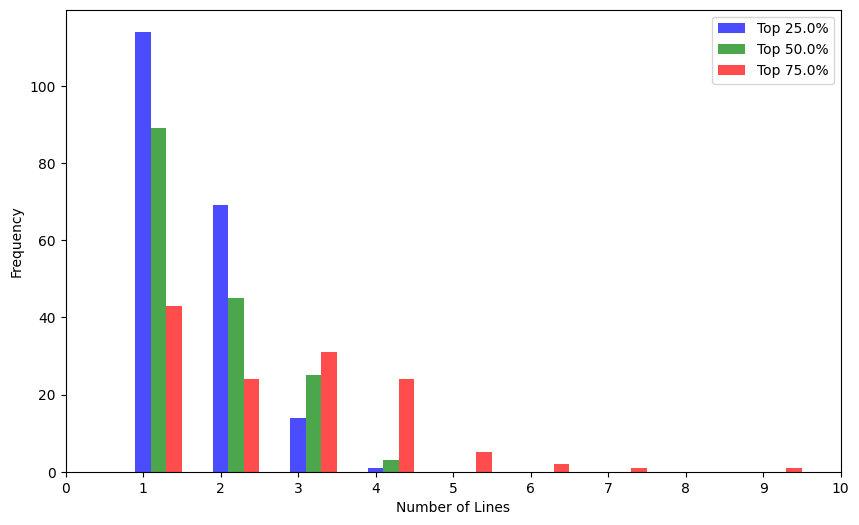

In [118]:

colors = plt.cm.tab10.colors
colors = ['blue', 'green', 'red'] 
plt.figure(figsize=(10, 6))

bar_width = 0.2  # Width of each bar
offsets = np.arange(len([0.1, 0.3, 0.5])) * bar_width  # Calculate offsets for each quantile

for i, quant in enumerate([0.25, 0.5, 0.75]):
    all_quants = [0.25, 0.5, 0.75]
    # Calculate quantiles
    if i == 0:
        cutoff_index = res_clean['CER'] <= res_clean['CER'].quantile(quant)
    else:
        cutoff_index = (res_clean['CER'] <= res_clean['CER'].quantile(quant)) & (res_clean['CER'] > res_clean['CER'].quantile(all_quants[i - 1]))
    tmp = res_clean[cutoff_index]["num_lines"].value_counts()
    #print(f"# of column lines for the top {quant}% quantile {tmp}")
    plt.bar(tmp.index + offsets[i], tmp.values, width=bar_width, color=colors[i], alpha=0.7, label=f'Top {quant*100}%')

plt.legend()
plt.xticks(np.arange(0, 11))
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')

repeat other way round: show the CER for the res with 1 

/tmp/ipykernel_256373/1935528423.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r', max_num_line)


Text(0.5, 1.0, 'Distribution of Character Error Rate (CER) by Number of Text Lines')

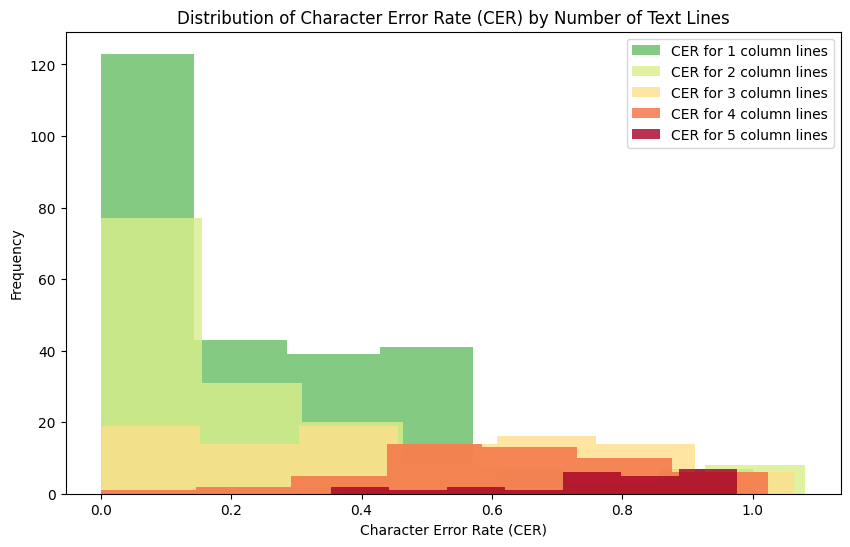

: 

In [201]:
plt.figure(figsize=(10, 6))
max_num_line = 6
cmap = plt.cm.get_cmap('RdYlGn_r', max_num_line) 
#seismic #coolwarm #RdBu
colors = [cmap(i) for i in range(cmap.N)]

#for i, num_line in enumerate(range(1, 3)):
for num_line in range(1, max_num_line):
    tmp = res_clean[res_clean['num_lines'] == num_line]["CER"]
    
    plt.hist(tmp, bins = 7,color=colors[num_line], alpha = 0.8, label=f'CER for {num_line} column lines')
    
plt.legend()
plt.xlabel("Character Error Rate (CER)")
plt.ylabel("Frequency")
plt.title("Distribution of Character Error Rate (CER) by Number of Text Lines")



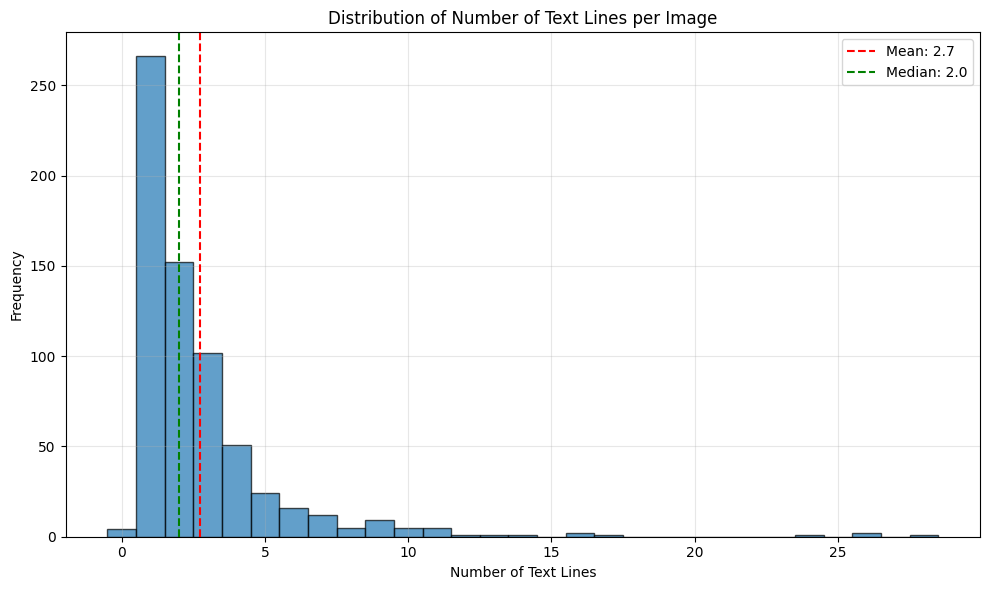

Total samples: 661
Mean lines: 2.72
Median lines: 2.0
Std lines: 2.93
Min lines: 0
Max lines: 28


In [62]:
# Plot histogram of text lines
import matplotlib.pyplot as plt
import numpy as np

# Extract num_lines values from the results
num_lines_values = res['num_lines'].values

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(num_lines_values, bins=range(min(num_lines_values), max(num_lines_values) + 2, 1), 
         edgecolor='black', alpha=0.7, align='left')
plt.xlabel('Number of Text Lines')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Text Lines per Image')
plt.grid(True, alpha=0.3)

# Add some statistics
mean_lines = np.mean(num_lines_values)
median_lines = np.median(num_lines_values)
plt.axvline(mean_lines, color='red', linestyle='--', label=f'Mean: {mean_lines:.1f}')
plt.axvline(median_lines, color='green', linestyle='--', label=f'Median: {median_lines:.1f}')
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
res[res["num_lines"]==3][0:1]


,ground_truth,num_lines,prediction,identifier,CER
1,王甲 唐甲 當事,3,唐甲 王甲 補事,12_21_p001_r_40,0.375


In [86]:
text = res[res["identifier"] == "12_21_p001_r_40"]["ground_truth"].iloc[0]
text.count(' ')

2

In [87]:
text = res[res["identifier"] == "12_21_p001_r_40"]["prediction"].iloc[0]
text.count(' ')

2

In [58]:
display_results(res, num_examples= 2)

Fix whitespaces?

In [52]:
res[0:2]

,ground_truth,num_lines,prediction,identifier,CER
0,美色甘 呌,2,美色甘呌,12_21_p001_r_31,0.200
1,王甲 唐甲 當事,3,唐甲 王甲 補事,12_21_p001_r_40,0.375


In [1]:
res

NameError: name 'res' is not defined

In [46]:
type(res)
res.shape

(300, 5)

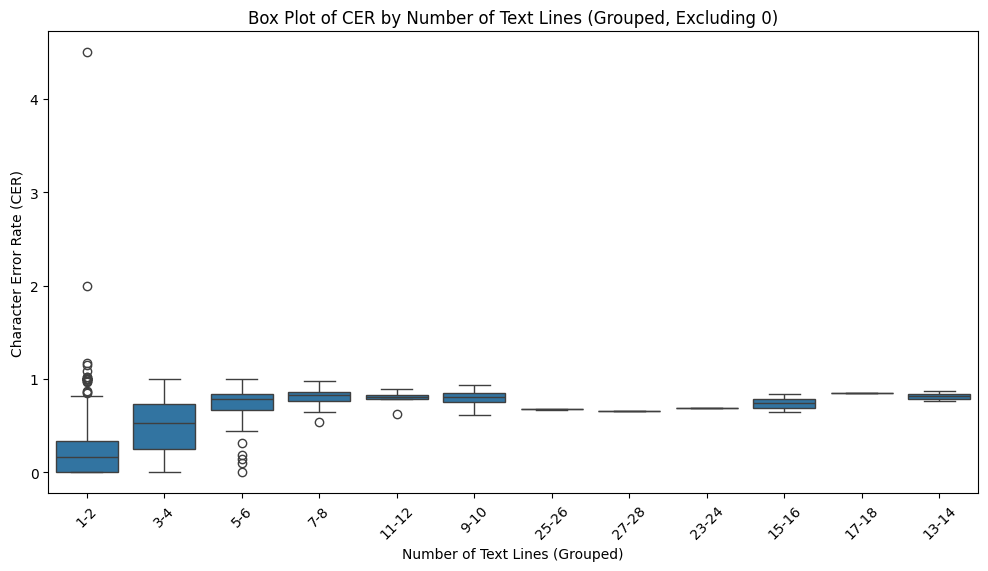

In [61]:
# Box plot with grouped bins
# plt.figure(figsize=(12, 6))

# # Create bins for num_lines: 0 stays separate, others grouped by 3
# res_binned = res.copy()
# res_binned['num_lines_binned'] = res_binned['num_lines'].apply(
#     lambda x: 0 if x == 0 else f"{(x-1)//2*2+1}-{((x-1)//2+1)*2}"
# )

# # Create box plot with binned data
# sns.boxplot(x='num_lines_binned', y='CER', data=res_binned)
# plt.title('Box Plot of CER by Number of Text Lines (Grouped)')
# plt.xlabel('Number of Text Lines (Grouped)')
# plt.ylabel('Character Error Rate (CER)')
# plt.xticks(rotation=45)
# Filter out rows where num_lines is 0
res_filtered = res[res['num_lines'] != 0]

# Box plot with grouped bins (excluding 0)
plt.figure(figsize=(12, 6))

# Create bins for num_lines: group by 3
res_binned = res_filtered.copy()
res_binned['num_lines_binned'] = res_binned['num_lines'].apply(
    lambda x: f"{(x-1)//2*2+1}-{((x-1)//2+1)*2}"
)

# Create box plot with binned data
sns.boxplot(x='num_lines_binned', y='CER', data=res_binned)
plt.title('Box Plot of CER by Number of Text Lines (Grouped, Excluding 0)')
plt.xlabel('Number of Text Lines (Grouped)')
plt.ylabel('Character Error Rate (CER)')
plt.xticks(rotation=45)
plt.show()

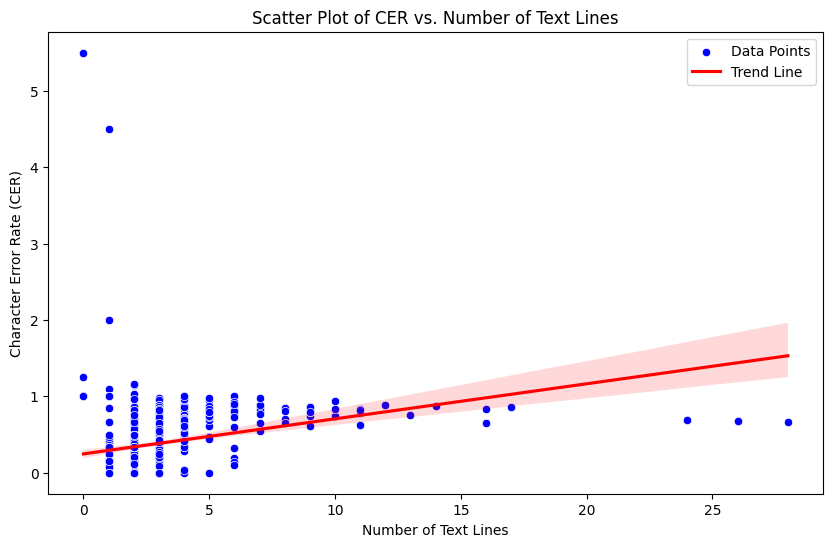

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
df = res
# Scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_lines', y='CER', data=df, color='blue', label='Data Points')
sns.regplot(x='num_lines', y='CER', data=df, scatter=False, color='red', label='Trend Line')
plt.title('Scatter Plot of CER vs. Number of Text Lines')
plt.xlabel('Number of Text Lines')
plt.ylabel('Character Error Rate (CER)')
plt.legend()
plt.show()

In [89]:
import pandas as pd
from collections import Counter

half_sample_size = round(res.shape[0] / 2)

# Function to analyze the DataFrame for highest and lowest CER values
#def analyze_cer(res):
    # Sort by CER
sorted_df = res.sort_values(by='CER', ascending=False)
# Get top 10 and bottom 10 entries
top_10 = sorted_df.tail(half_sample_size).dropna()
bottom_10 = sorted_df.head(half_sample_size).dropna()

# Analyze Chinese symbols in top and bottom 10
top_symbols = Counter(''.join(top_10['ground_truth']))
bottom_symbols = Counter(''.join(bottom_10['ground_truth']))
# Get most common symbols
top_common_symbols = top_symbols.most_common(10)
bottom_common_symbols = bottom_symbols.most_common(10)


# Analyze prediction lengths
top_lengths = top_10['prediction'].apply(len)
bottom_lengths = bottom_10['prediction'].apply(len)

# Print analysis
print("Top 10 CER Analysis:")
print("Most common symbols:", top_common_symbols)
print("Prediction lengths:", top_lengths.describe())

print("\nBottom 10 CER Analysis:")
print("Most common symbols:", bottom_common_symbols)
print("Prediction lengths:", bottom_lengths.describe())

# Additional analysis suggestions
# - Compare CER with prediction length
# - Visualize CER distribution
# - Analyze correlation between CER and specific symbols


Top 10 CER Analysis:
Most common symbols: [(' ', 223), ('覌', 120), ('呌', 114), ('陳', 62), ('甲', 55), ('不', 46), ('日', 43), ('到', 41), ('月', 35), ('二', 32)]
Prediction lengths: count    330.000000
mean       8.675758
std       16.082075
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max      126.000000
Name: prediction, dtype: float64

Bottom 10 CER Analysis:
Most common symbols: [(' ', 951), ('錢', 282), ('文', 264), ('不', 218), ('拾', 207), ('有', 190), ('陳', 164), ('供', 163), ('壹', 151), ('一', 148)]
Prediction lengths: count    324.00000
mean      38.87963
std       42.58193
min        1.00000
25%        5.00000
50%       17.00000
75%       68.00000
max      139.00000
Name: prediction, dtype: float64


In [97]:
# Filter for single column text regions
single_column_res = res[res['num_lines'] == 1].copy()
# Remove any rows with NaN values
single_column_res = single_column_res.dropna()
# Remove rows with None values in any column
single_column_res = single_column_res.dropna()

# Also remove rows where ground_truth or prediction is None specifically
single_column_res = single_column_res[
    (single_column_res['ground_truth'].notna()) & 
    (single_column_res['prediction'].notna())
]

# Convert to string type to ensure no None values remain
single_column_res['ground_truth'] = single_column_res['ground_truth'].astype(str)
single_column_res['prediction'] = single_column_res['prediction'].astype(str)


# Analyze which Chinese characters are most commonly predicted incorrectly
def analyze_character_errors(ground_truth, prediction):
    """Analyze character-level errors between ground truth and prediction"""
    errors = []
    gt_chars = list(ground_truth)
    pred_chars = list(prediction)
    
    # Use difflib to find differences
    d = difflib.Differ()
    diff = list(d.compare(gt_chars, pred_chars))
    
    for i, s in enumerate(diff):
        if s.startswith('- '):  # Character in ground truth but not in prediction
            errors.append(('deleted', s[2:]))
        elif s.startswith('+ '):  # Character in prediction but not in ground truth
            errors.append(('inserted', s[2:]))
    
    return errors


In [98]:
single_column_res

,ground_truth,num_lines,prediction,identifier,CER
2,23,1,志,12_21_p001_r_2,1.000000
4,髙桃覌,1,高桃覌,12_21_p001_r_16,0.333333
8,王祖覌,1,王祖覌,12_21_p001_r_1416,0.000000
10,22,1,22,12_21_p001_r,0.000000
12,76,1,76,32_41_p008_r,0.000000
...,...,...,...,...,...
647,陳鵠覌呌,1,陳鵲覌呌,22_31_p003_r_32,0.250000
648,黃會覌呌,1,黄會覌呌,22_31_p003_r_30,0.250000
650,蔡玉振,1,蔡玉振,22_31_p003_r_33,0.000000
655,戊二月廿六日和〡〧〨〨年四月初二日拜三,1,戊二年六月廿六日和〡〧〨〧年四月初二日拜三,22_31_p003_r_29,0.157895


In [ ]:

# Analyze all errors in the dataset
all_errors = []
for _, row in single_column_res.iterrows():
    errors = analyze_character_errors(row['ground_truth'], row['prediction'])
    all_errors.extend(errors)


In [102]:

# Count error types
error_counts = Counter([error[1] for error in all_errors])
deletion_counts = Counter([error[1] for error in all_errors if error[0] == 'deleted'])
insertion_counts = Counter([error[1] for error in all_errors if error[0] == 'inserted'])

print("Most commonly deleted characters:")
for char, count in deletion_counts.most_common(10):
    print(f"'{char}': {count} times")

print("\nMost commonly inserted characters:")
for char, count in insertion_counts.most_common(10):
    print(f"'{char}': {count} times")

print(f"\nTotal character errors: {len(all_errors)}")
print(f"Total deletions: {len([e for e in all_errors if e[0] == 'deleted'])}")
print(f"Total insertions: {len([e for e in all_errors if e[0] == 'inserted'])}")

# Create a DataFrame for better analysis
error_df = pd.DataFrame(all_errors, columns=['error_type', 'character'])
error_summary = error_df.groupby(['error_type', 'character']).size().reset_index(name='count')
error_summary = error_summary.sort_values('count', ascending=False)

print("\nTop 20 most common character errors:")
print(error_summary.head(20))


Most commonly deleted characters:
'〨': 13 times
'〧': 8 times
'拜': 7 times
'黃': 6 times
'初': 6 times
'〡': 6 times
'3': 5 times
'年': 5 times
'囬': 5 times
' ': 5 times

Most commonly inserted characters:
' ': 45 times
'〧': 7 times
'寕': 6 times
'黄': 6 times
'覌': 5 times
'的': 4 times
'5': 4 times
'2': 4 times
'金': 3 times
'回': 3 times

Total character errors: 546
Total deletions: 254
Total insertions: 292

Top 20 most common character errors:
    error_type character  count
139   inserted               45
15     deleted         〨     13
14     deleted         〧      8
159   inserted         〧      7
78     deleted         拜      7
136    deleted         黃      6
211   inserted         寕      6
34     deleted         初      6
315   inserted         黄      6
12     deleted         〡      6
281   inserted         覌      5
5      deleted         3      5
69     deleted         年      5
54     deleted         囬      5
0      deleted                5
76     deleted         愿      4
82     deleted

In [26]:
cases_with_spaces = bottom_10[bottom_10['ground_truth'].str.contains(' ')]
                               #|bottom_10['prediction'].str.contains(' ')]
    
# Extract two cases
cases_with_spaces.iloc[1, ]


ground_truth    陳德蘭供谓李寕二前去山枋壁磚灰鉄对除外尚 長去銭叁拾四文弍犮五方屡讨不还李寕二供谓欠 德蘭之...
prediction      德蘭 之子 有之 呌若 之 多 列 呌谕 二 比在外 会 算 长古自叁拾四文 武文 五方 属...
identifier                                    32_41_0001_p001_r_6
CER                                                      1.063492
Name: 5, dtype: object

In [39]:
top_10

,ground_truth,prediction,identifier,CER
46,削視 人 鄭顧覌 張玉郎,削人鄭顧覌 視張玉郎,12_21_0009_p009_r_12,0.333333
36,吳度覌,吳慶覌,01_11_0008_p008_r_25,0.333333
97,削視 人 黄百合 張宙覌,削人黄百合 視張宙覌,32_41_0009_p009_r_8,0.333333
124,鄭春覌 二期 不到,鄭春覌 不到,12_21_0005_p005_r_15,0.333333
114,李寧二,李寕二,22_31_0008_p008_r_3,0.333333
...,...,...,...,...
105,邹富覌 呌,邹富覌 呌,12_21_0004_p004_r_9,0.000000
123,陳端舍呌,陳端舍呌,22_31_0007_p007_r_15,0.000000
119,22,22,12_21_0001_p001_r,0.000000
130,李寕義,李寕義,12_21_0002_p002_r_524,0.000000


In [40]:
bottom_10   

,ground_truth,prediction,identifier,CER
45,46,47 58,22_31_0003_p003_r_322,2.000000
107,無再𨂻前轍列𦤼赦宥不究 寅突入卧房毆打是以有與他互毆懇𦤼開恩赦宥斷,寅interop序殴打是已有其他互殴案 臺间恩叔審影 身再蹈前輓列表救寘不究,12_21_0007_p007_r,1.151515
62,又囬家之信係林次老所寄祈为審实 林盛为前年陳𤆬有欠去貨銭供详前期四月十六日,林盛为前年陈焦有欠李货钱供详前期四月十六日 文回家之后信橡林次老听寄说为审实,32_41_0003_p003_r_3,1.027027
56,伊家傭工即将鞋籠物器交寄寜義代収工竣之日工錢既已 向寕義取讨所寄鞋籠々内有鞋刀三枝釘槌壹枝鞋...,百餘條釁鑼土枝紳笏頭裈半條-ln切刀三枝鑽仔八枝剪刀一枝 伊家僱工即將鞋籠物罌交寄寧義代收工...,12_21_0002_p002_r_16,0.951220
120,至今不還本日對舍侄還來錢叁拾文貳鈸除外尚欠去錢叁拾文貳 湯新供謂去歲六月十一日葉亞六去錢陸拾...,至今不還奉日对金赃还赃日叁拾又口径除往外尚欠去日叁拾又口径 萬壹六乞限壹年六月清楚 溝新供渭...,01_11_0005_p005_r_8,0.906667
...,...,...,...,...
25,三阄 黄甲 林甲,三圍 黃甲 林,12_21_0003_p003_r_590,0.375000
16,王興廣供謂鄭旺伯前期在公堂坐欠去錢陸拾柒文貳鈸後他,王興廣供謂鄭旺均前期在庲堂坐欠李子誥拾得文武成後地,01_11_0005_p005_r_7,0.360000
121,圡庫内案奪为李璉一事存案,去庫内案奪為李連一案存案,32_41_0005_p005_r_7,0.333333
92,陳寬覌,陳寕覌,22_31_0007_p007_r_16,0.333333


In [74]:
print(top_lengths)
top_10

82     1
83     3
74     3
79     8
113    3
105    5
123    4
119    2
130    3
131    3
Name: prediction, dtype: int64


,ground_truth,prediction,identifier,CER
82,5,5,01_11_0003_p003_r_2,0.0
83,陳約覌,陳約覌,22_31_0005_p005_r_5,0.0
74,鄭旺伯,鄭旺伯,01_11_0002_p002_r_81,0.0
79,陳甲 楊甲 當事,陳甲 楊甲 當事,22_31_0009_p009_r_13,0.0
113,朱金覌,朱金覌,32_41_0008_p008_r_8,0.0
105,邹富覌 呌,邹富覌 呌,12_21_0004_p004_r_9,0.0
123,陳端舍呌,陳端舍呌,22_31_0007_p007_r_15,0.0
119,22,22,12_21_0001_p001_r,0.0
130,李寕義,李寕義,12_21_0002_p002_r_524,0.0
131,陳馬援,陳馬援,22_31_0001_p001_r_36,0.0


In [41]:
def plot_prediction_lengths_histogram(df, num_predictions=10):
    # Sort by CER
    sorted_df = df.sort_values(by='CER', ascending=True)
    
    # Get top and bottom entries
    top_entries = sorted_df.head(num_predictions)
    bottom_entries = sorted_df.tail(num_predictions)
    
    # Analyze prediction lengths
    top_lengths = top_entries['prediction'].apply(len)
    bottom_lengths = bottom_entries['prediction'].apply(len)
    
    # Determine the range for the bins
    min_length = min(top_lengths.min(), bottom_lengths.min())
    max_length = max(top_lengths.max(), bottom_lengths.max())
    bins = range(min_length, max_length + 1)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(top_lengths, bins=bins, alpha=0.5, label='Top CER Predictions', color='red')
    plt.hist(bottom_lengths, bins=bins, alpha=0.5, label='Bottom CER Predictions', color='blue')
    plt.xlabel('Prediction Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Prediction Lengths')
    plt.legend(loc='upper right')
    plt.show()

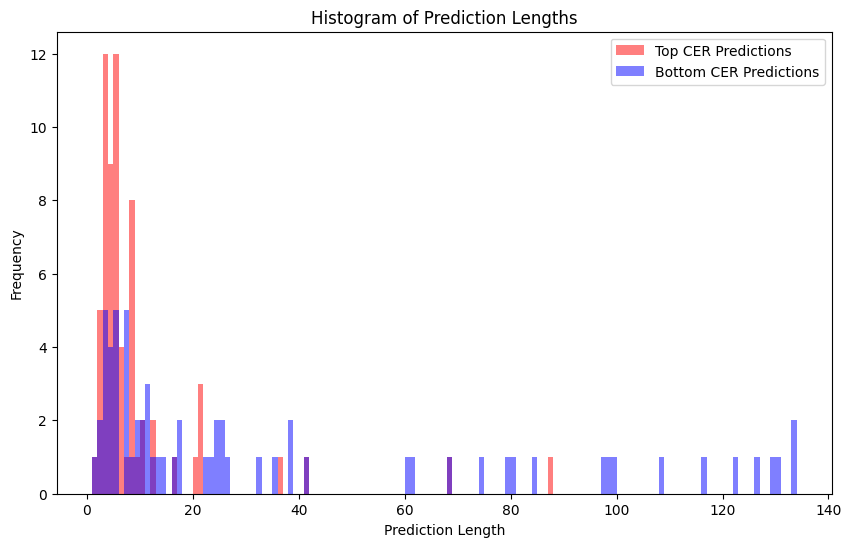

In [42]:
plot_prediction_lengths_histogram(res, num_predictions=round(res.shape[0]/2)) 